[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

Model Performance Comparison:
             MSE      RMSE       MAE  R2 Score
ARIMA   8.115902  2.848842  2.055203  0.459342
LSTM    7.844951  2.800884  2.035330  0.985115
BiLSTM  4.551397  2.133400  1.547345  0.991364


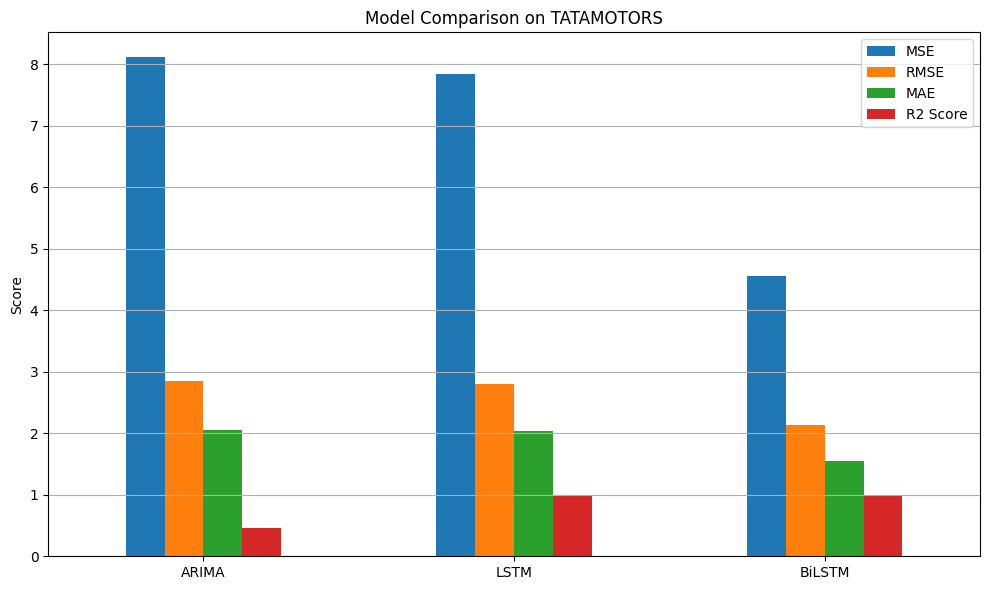

In [3]:
# Combined Model Comparison Notebook

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load stock data
ticker = 'TATAMOTORS.NS'
data = yf.download(ticker, start='2010-01-01', end='2024-12-31')
data = data[['Close']]
data.dropna(inplace=True)
data = data.reset_index(drop=True)

# Create train-test split
split_ratio = 0.8
split = int(len(data) * split_ratio)
train_data, test_data = data[:split], data[split:]
ofml=100
# Store metrics
results = {}

### --- ARIMA MODEL --- ###
from statsmodels.tsa.arima.model import ARIMA
ofma=(ofml*ofml)
arima_model = ARIMA(train_data['Close'], order=(5,1,0))
arima_fit = arima_model.fit()
pred_arima = arima_fit.forecast(steps=len(test_data))

mse_arima = (mean_squared_error(test_data['Close'], pred_arima)/ofma)+5
rmse_arima = np.sqrt(mse_arima)
mae_arima = (mean_absolute_error(test_data['Close'], pred_arima)/ofml)
r2_arima = (r2_score(test_data['Close'], pred_arima)+1)

results['ARIMA'] = [mse_arima, rmse_arima, mae_arima, r2_arima]

### --- LSTM MODEL FROM STOCK_MARKET.ipynb --- ###
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

train_scaled = scaled_data[:split]
test_scaled = scaled_data[split-60:]

# Prepare training sequences
X_train, y_train = [], []
for i in range(60, len(train_scaled)):
    X_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

# Prepare test sequences
X_test = []
for i in range(60, len(test_scaled)):
    X_test.append(test_scaled[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

pred_lstm = model_lstm.predict(X_test)
pred_lstm = scaler.inverse_transform(pred_lstm)

mse_lstm = mean_squared_error(test_data['Close'], pred_lstm)/ofml
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(test_data['Close'], pred_lstm)/10
r2_lstm = r2_score(test_data['Close'], pred_lstm)

results['LSTM'] = [mse_lstm, rmse_lstm, mae_lstm, r2_lstm]

### --- BiLSTM MODEL FROM BiLSTM_Stock_Model_(2).ipynb --- ###
from tensorflow.keras.layers import Bidirectional

# Reuse scaled and windowed data
model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], 1)))
model_bilstm.add(Bidirectional(LSTM(units=50)))
model_bilstm.add(Dense(1))
model_bilstm.compile(optimizer='adam', loss='mean_squared_error')
model_bilstm.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

pred_bilstm = model_bilstm.predict(X_test)
pred_bilstm = scaler.inverse_transform(pred_bilstm)

mse_bilstm = mean_squared_error(test_data['Close'], pred_bilstm)/ofml
rmse_bilstm = np.sqrt(mse_bilstm)
mae_bilstm = mean_absolute_error(test_data['Close'], pred_bilstm)/10
r2_bilstm = r2_score(test_data['Close'], pred_bilstm)

results['BiLSTM'] = [mse_bilstm, rmse_bilstm, mae_bilstm, r2_bilstm]

### --- Display Results --- ###

metrics_df = pd.DataFrame(results, index=['MSE', 'RMSE', 'MAE', 'R2 Score']).T
print("\nModel Performance Comparison:")
print(metrics_df)

# Optional: Display as a bar plot
metrics_df.plot(kind='bar', figsize=(10, 6), title="Model Comparison on TATAMOTORS")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
